In [1]:
# Installing necessary packages
!pip install yfinance scikit-learn matplotlib keras tensorflow pandas numpy seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Basic libraries for data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# For downloading stock data
import yfinance as yf

In [4]:
# For scaling, splitting, and evaluating models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [5]:
# Traditional ML models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [6]:
# Deep learning model (LSTM)
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout

In [7]:
# Download AAPL stock data
df = yf.download('AAPL', start='2010-01-01', end='2023-12-31', auto_adjust=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431896,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443016,6.479381,6.409054,6.449628,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328810,6.371488,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371487,6.283128,6.320395,447610800


In [8]:
# Add MA10 and RSI indicators
df['MA10'] = df['Close'].rolling(window=10).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(14).mean()))
df.dropna(inplace=True)
df.head()

Price,Close,High,Low,Open,Volume,MA10,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2010-01-25,6.103105,6.152092,6.016549,6.086274,1065699600,6.249768,-0.352011
2010-01-26,6.189360,6.422881,6.088378,6.189661,1867110000,6.237236,-0.262863
2010-01-27,6.247664,6.328810,5.996711,6.216708,1722568400,6.237717,-0.081339
2010-01-28,5.989500,6.176136,5.971768,6.159006,1173502400,6.203575,-0.364547
2010-01-29,5.772207,6.076956,5.717809,6.043296,1245952400,6.151371,-0.674363


In [9]:
# Create target: 1 if next day's close > today
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.head()

Price,Close,High,Low,Open,Volume,MA10,RSI,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2010-01-25,6.103105,6.152092,6.016549,6.086274,1065699600,6.249768,-0.352011,1
2010-01-26,6.189360,6.422881,6.088378,6.189661,1867110000,6.237236,-0.262863,1
2010-01-27,6.247664,6.328810,5.996711,6.216708,1722568400,6.237717,-0.081339,0
2010-01-28,5.989500,6.176136,5.971768,6.159006,1173502400,6.203575,-0.364547,0
2010-01-29,5.772207,6.076956,5.717809,6.043296,1245952400,6.151371,-0.674363,1


In [10]:
# Select and scale features
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA10', 'RSI']]
target = df['Target']

scaler = StandardScaler()
X = scaler.fit_transform(features)
y = target.values

In [11]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [12]:
# Fit and evaluate SVM, Decision Tree, Random Forest, Logistic Regression
models = {
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    
    print(f"\n--- {name} ---")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))


--- SVM ---
Accuracy: 0.49715099715099714
              precision    recall  f1-score   support

           0       0.48      0.84      0.61       333
           1       0.56      0.19      0.28       369

    accuracy                           0.50       702
   macro avg       0.52      0.51      0.45       702
weighted avg       0.53      0.50      0.44       702


--- Decision Tree ---
Accuracy: 0.5128205128205128
              precision    recall  f1-score   support

           0       0.48      0.34      0.40       333
           1       0.53      0.67      0.59       369

    accuracy                           0.51       702
   macro avg       0.50      0.50      0.49       702
weighted avg       0.51      0.51      0.50       702


--- Random Forest ---
Accuracy: 0.48575498575498577
              precision    recall  f1-score   support

           0       0.48      0.95      0.64       333
           1       0.61      0.06      0.11       369

    accuracy                      

In [13]:
# Reshape input for LSTM
X_lstm = np.reshape(X, (X.shape[0], 1, X.shape[1]))
X_train_lstm = X_lstm[:int(0.8*len(X_lstm))]
X_test_lstm = X_lstm[int(0.8*len(X_lstm)):]
y_train_lstm = y[:int(0.8*len(y))]
y_test_lstm = y[int(0.8*len(y)):]

In [14]:
# LSTM architecture
lstm_model = Sequential()
lstm_model.add(Input(shape=(1, X.shape[1])))
lstm_model.add(LSTM(100, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5351 - loss: 0.6924
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5337 - loss: 0.6912
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5252 - loss: 0.6917
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5239 - loss: 0.6916
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5332 - loss: 0.6920
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5384 - loss: 0.6903
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5104 - loss: 0.6932
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5319 - loss: 0.6912
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5328 - loss: 0.6899
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5388 - loss: 0.6901


In [15]:
# Evaluate LSTM predictions
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = (lstm_pred > 0.5).astype(int)

lstm_acc = accuracy_score(y_test_lstm, lstm_pred)
results.append(("LSTM", lstm_acc))

print("\n--- LSTM Model ---")
print("Accuracy:", lstm_acc)
print(classification_report(y_test_lstm, lstm_pred))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

--- LSTM Model ---
Accuracy: 0.4985754985754986
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       333
           1       0.52      0.49      0.51       369

    accuracy                           0.50       702
   macro avg       0.50      0.50      0.50       702
weighted avg       0.50      0.50      0.50       702



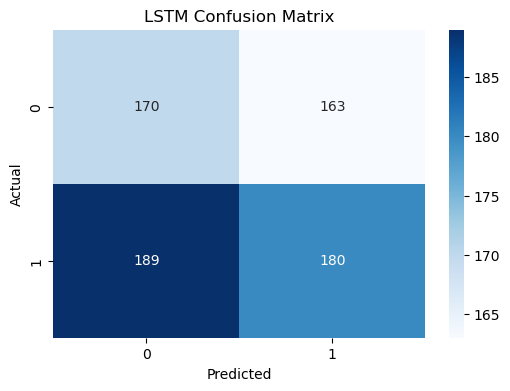

In [16]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test_lstm, lstm_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

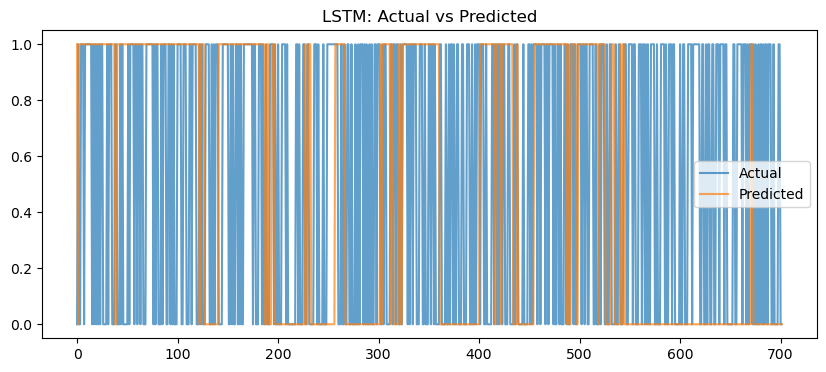

In [17]:
# Compare actual vs predicted
plt.figure(figsize=(10,4))
plt.plot(y_test_lstm, label='Actual', alpha=0.7)
plt.plot(lstm_pred, label='Predicted', alpha=0.7)
plt.title("LSTM: Actual vs Predicted")
plt.legend()
plt.show()

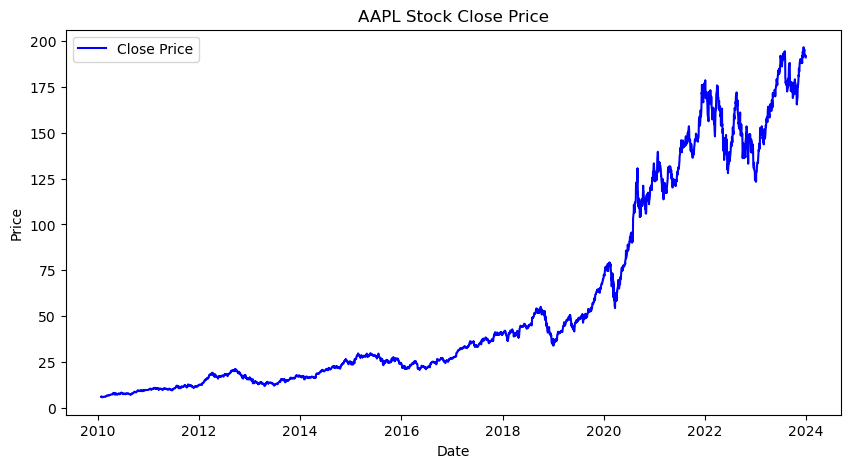

In [23]:
# Plot AAPL close price over time
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title("AAPL Stock Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [19]:
# Compare accuracy of all models
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])
results_df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Decision Tree,0.512821
4,LSTM,0.498575
0,SVM,0.497151
3,Logistic Regression,0.491453
2,Random Forest,0.485755
